## [Cobaya Blocks](#cobaya-blocks)
- [Parameter Block](#parameter-block)
  - [Sampled Parameters](#sampled-parameters)
  - [Derived Parameters](#derived-parameters)
- [Likelihood Block](#likelihood-block)
- [Theories Block](#theories-block)

## [Computing with Cobaya](#computing-with-cobaya)
- [Building the Configuration Dictionary](#building-the-configuration-dictionary)
- [Fiducial Parameter Values and Log-Posterior Evaluation](#fiducial-parameter-values-and-log-posterior-evaluation)
- [From a Python Dictionary to a YAML Configuration](#from-a-python-dictionary-to-a-yaml-configuration)
- [Sampler Block](#sampler-block)
- [Running Cobaya from the Notebook](#running-cobaya-from-the-notebook)

## [Explore the Data](#explore-the-data)
- [Inspecting the MFLike Data](#inspecting-the-mflike-data)
- [Accessing Theory and Data](#accessing-theory-and-data)
- [How they Combine](#how-they-combine)

## [Adding More Data: Lensing Likelihood](#adding-more-data-lensing-likelihood)
- [Inspecting the Lensing Data](#inspecting-the-lensing-data)


## Introduction

SOLikeT is the Simons Observatory (SO) Likelihood and Theory code. It exists to provide a way of doing inference on cosmological models using Simons Observatory data. The goal is to generate measurements of cosmological parameters from the input of reduced, science-ready data from SO.

SOLikeT consists of a number of modules which either:
- Compute a likelihood: read in data, apply any necessary data transformations, accept predicted data from a Theory module and compare the data to the prediction using an appropriate likelihood function.
- Compute a theory: take in a set of cosmological, calibration and nuisance parameters, and use numerical models to predict the SO data assuming the given values of the parameters.

The output of this is a joint posterior distribution on the model parameters, from different types of SO data (primary CMB, CMB lensing, galaxy cluster number counts, cross-correlations with external large-scale structure tracers).

### Relationship to Cobaya
[Cobaya](https://cobaya.readthedocs.io/en/latest/) is a framework for performing Bayesian analyses in cosmology: specifying likelihoods, priors and theoretical predictions, and performing Monte Carlo random sampling to estimate the resulting posterior from a variety of data sets. Cobaya itself contains multiple theory and likelihood modules, many of which are useful for SOLikeT

SOLikeT is a set of Cobaya theory and likelihood modules which are being constructed by the Simons Observatory collaboration to analyse SO data sets.

### Relationship to other SO Pipeline Components
SOLikeT turns science ready data products (i.e. power spectra) into posterior parameter estimates. Going from raw timestream data from the observatory to power spectra is performed by other SO pipeline packages:
* [PSPipe](https://github.com/simonsobs/PSpipe) is used for going from CMB maps to multi-frequency temperature and polarisation power spectra


## Cobaya Blocks

Cobaya input files contain multiple blocks which specify the data likelihoods, theoretical computations, and parameters (with priors) to use. These can either be created as stand-alone `yaml` files, or directly in a python script as a `dict` object.

Here we write things initially directly as a `dict` but the equivalent `yaml` is also created later on, and we could have chosen to write this only instead.

### Parameter Block

Cobaya organizes model parameters into a single **parameter block** that tells the sampler what to vary, how to constrain them, and what quantities to compute from them.

**Sampled Parameters**  
The core variables the MCMC explores during parameter estimation

**Derived Parameters**  
Quantities computed from sampled parameters



### Sampled Parameters

For each sampled parameter, you define:

**Priors**  
Define allowed ranges or distributions for each parameter. For example, `theta_MC_100`, `logA`, `ombh2`, `omch2`, `ns` use uniform bounds; `tau` uses a Gaussian prior due to SO configuration.

**Reference values (`refs`)**  
Provide sensible starting points or informative reference distributions, often taken from fiducial or previous constraints.

**Proposal widths (`proposals`)**  
Set the step size for the MCMC proposals per parameter. Smaller values lead to finer exploration; larger values move faster but may reduce acceptance.

**Labels**  
LaTeX names for clear plots and outputs.

In [1]:
params_sampled = ["theta_MC_100", "logA", "ombh2", "omch2", "ns", "tau"]

priors = {
    "theta_MC_100": dict(min=0.5, max=10),
    "logA": dict(min=2.5, max=3.5),
    "ombh2": dict(min=0.0195, max=0.025),
    "omch2": dict(min=0.09, max=0.15),
    "ns": dict(min=0.8, max=1.2),
    "tau": dict(dist="norm", loc=0.0544, scale=0.0073),
}

refs = {
    "theta_MC_100": dict(dist="norm", loc=1.0409, scale=0.0004),
    "logA": dict(dist="norm", loc=3.045, scale=0.005),
    "ombh2": dict(dist="norm", loc=0.02236, scale=1.0e-05),
    "omch2": dict(dist="norm", loc=0.1202, scale=0.0001),
    "ns": dict(dist="norm", loc=0.9649, scale=0.0005),
    "tau": dict(dist="norm", loc=0.0544, scale=0.0001),
}

proposals = {
    "theta_MC_100": 0.0001,
    "logA": 0.01,
    "ombh2": 0.0001,
    "omch2": 0.001,
    "ns": 0.001,
    "tau": 0.001,
}

latex = {
    "theta_MC_100": r"100\theta_\mathrm{MC}",
    "logA": r"\log(10^{10} A_\mathrm{s})",
    "ombh2": r"\Omega_\mathrm{b} h^2",
    "omch2": r"\Omega_c h^2",
    "ns": r"n_s",
    "tau": r"\tau_\mathrm{reio}",
}

### Derived Parameters

There are different ways to handle derived parameters:

**Bounds-only**  
Enforce a valid range for parameters not sampled (e.g., `H0` min/max).

**Derived-only**  
Mark quantities computed from sampled parameters that are wanted to be reported (e.g., `omega_de`, `omegam`) but not sampled.

**Derived with a function**  
Define explicit formulas to compute new parameters.

**Drops (`drop: True`)**   
Used for a parameter that is sampled but the likelihood or theory does not recognise it as an input. (e.g., drop `theta_MC_100` and `logA` in favor for `cosmomc_theta` and `As`). **NB** `derived=False` tells that `cosmomc_theta` should not be a reported parameter whereas `As` appears as an output column in the chains

**Renames (`renames`)**  
Provide alternative names (aliases).

In [2]:
params_derived = ["H0", "As", "omega_de", "omegam", "omegamh2"]

bounds_only = {"H0": dict(min=40, max=100)}


derived_only = {"omega_de": dict(derived=True), "omegam": dict(derived=True)}


derived_with_functions = {
    "cosmomc_theta": dict(value="lambda theta_MC_100: 1.e-2*theta_MC_100", derived=False),
    "As": dict(value="lambda logA: 1e-10*np.exp(logA)"),
    "omegamh2": dict(derived="lambda omegam, H0: omegam*(H0/100)**2"),
}

drops = {"theta_MC_100": True, "logA": True}


renames = {"theta_MC_100": "theta", "ombh2": ["omegabh2"], "omega_de": ["omegal"]}


latex.update(
    {
        "H0": r"H_0",
        "As": r"A_\mathrm{s}",
        "omega_de": r"\Omega_\Lambda",
        "omegam": r"\Omega_\mathrm{m}",
        "omegamh2": r"\Omega_\mathrm{m} h^2",
    }
)

This cell merges all parameter specifications into a single `params_block` dictionary that Cobaya understands.

In [3]:
params_block = {}

for p in params_sampled:
    params_block[p] = {
        "prior": priors[p],
        "ref": refs[p],
        "proposal": proposals[p],
        "latex": latex.get(p),
    }
for p, spec in bounds_only.items():
    params_block[p] = {"latex": latex.get(p), **spec}

for p, spec in derived_with_functions.items():
    params_block[p] = {**spec}
    if p in latex:
        params_block[p]["latex"] = latex.get(p)

for p, spec in derived_only.items():
    params_block[p] = {"latex": latex.get(p), **spec}
    if p in renames:
        params_block[p]["renames"] = renames[p]

for p, L in latex.items():
    params_block.setdefault(p, {})
    params_block[p].setdefault("latex", L)
    if p in drops:
        params_block[p]["drop"] = drops[p]
    if p in renames:
        params_block[p]["renames"] = renames[p]

### Likelihood block

The *likelihood* block tells Cobaya which data to compare against theory predictions. Each likelihood computes the probability of observing the data given a set of model parameters.  

For the primary CMB multi-frequency likelihood [MFLike](https://github.com/simonsobs/LAT_MFLike), the configuration includes:

**Data files** 
  - Path to the data folder
  - input file which, if it doesn't include a covariance matrix, should be paired with another file in `cov_Bbl_file`
  - maximum $\ell$ for theory computation.  

**Experiments**  
- List of frequency channels (e.g., `["LAT_93", "LAT_145", "LAT_225"]` for 93, 145, 225 GHz).
- spectra contains all the cross-spectra to include (e.g., auto- and cross-correlations between frequencies).

**Requested Cls**  
Which power spectra types to compute.  

**Defaults**: 
  - `polarizations`: Which spectra combinations to use (`["TT", "TE", "ET", "EE"]`).
  - `scales`: $\ell$ ranges for each spectrum.
  - `symmetrize`: Whether to symmetrize TE and ET (typically False if treating them independently).


---
**NB** Here we explicitly add some fields that can generally be omitted. In `_MFLike.yaml`, the default values for some of these parameters are defined and will be used if they are omitted. Also the MFLike likelihood has multiple subclasses corresponding to different spectra combinations (e.g. `TT`,`TTEE`,`TTTE` ... ) each of which sets specific default values that can be found in `TT.yaml`,`TTEE.yaml`,`TTTE.yaml` ... 

---

In [4]:
data_files = dict(
    data_folder="MFLike/v0.8",
    input_file="LAT_simu_sacc_00000.fits",
    cov_Bbl_file="data_sacc_w_covar_and_Bbl.fits",
    lmax_theory=10000,
)


experiments = ["LAT_93", "LAT_145", "LAT_225"]
spectra = [
    {"experiments": [a, b]} for i, a in enumerate(experiments) for b in experiments[i:]
]
data = dict(experiments=experiments, spectra=spectra)

requested_cls = ["tt", "te", "ee"]

defaults = dict(
    polarizations=["TT", "TE", "ET", "EE"],
    scales={"TT": [30, 9000], "TE": [30, 9000], "ET": [30, 9000], "EE": [30, 9000]},
    symmetrize=False,
)

mflike_config = {
    **data_files,
    "data": data,
    "requested_cls": requested_cls,
    "defaults": defaults,
}

**Downloading the data:** If the mflike data is not yet downloaded, the cell below takes care of it. It requires mflike to be installed 

In [5]:
from cobaya.install import install
from cobaya.tools import resolve_packages_path

packages_path = resolve_packages_path()

install(
    {"likelihood": {"mflike.TTTEEE": mflike_config}},
    path=packages_path,
    skip_global=False,
    force=False,
    debug=True,
    no_set_global=True,
)

 2026-02-02 16:35:51,505 [install] Installing external packages at '/Users/matteoforconi/Documents/GitHub/LAT_MFLike'

likelihood:mflike.TTTEEE

 2026-02-02 16:35:51,654 [install] 'mflike.TTTEEE' could not be found as internal, trying external.
 2026-02-02 16:35:52,191 [root] Numba not available, install it for better performance.
 2026-02-02 16:35:52,201 [install] Checking if dependencies have already been installed...
 2026-02-02 16:35:52,258 [install] External dependencies for this component already installed.
 2026-02-02 16:35:52,259 [install] Doing nothing.

* Summary * 

 2026-02-02 16:35:52,259 [install] All requested components' dependencies correctly installed at /Users/matteoforconi/Documents/GitHub/LAT_MFLike


True

### Theories Block

The *theory* block tells Cobaya how to compute theoretical predictions from cosmological parameters. The likelihood then compares those predictions to the data.

**Boltzmann solver (cosmology theory)**  
You can use for example **CAMB** or **CLASS**. Accuracy, lensing, and other settings can be tuned via `extra_args`. **Important:** CAMB and CLASS use different parameter naming conventions (e.g., `ombh2` vs `omega_b`, `tau` vs `tau_reio`). In what follows, CAMB has been used. If CLASS is used instead, the parameter block must be modified accordingly


**Foreground theory (MFLike)**  
MFLike also requires a foreground model. **BandpowerForeground** needs:
- the requested spectra (e.g. `TT`, `TE`, `EE`, …),
- the multipole range ($\ell$ range),
- the experiment names,
- the observing frequencies for multifrequency modelling.

---
**NB** Similarly to the likelihood case, we explicitly add some fields that can generally be omitted. In `Foreground.yaml`, the default values for some of these parameters are defined and will be used if they are omitted. Also here there are multiple subclasses corresponding to different spectra combinations each of which sets specific default values that can be found at the end of `foreground.py` 

---

In [6]:
theory_cosmo = {
    "camb": {
        "extra_args": {
            "lens_potential_accuracy": 8,
            "lens_margin": 2050,
            "WantTransfer": True,
            "Transfer.high_precision": True,
            "Transfer.kmax": 1.2,
            "num_nu_massless": 1.044,
        }
    },
    "classy": {
        "extra_args": {
            "non_linear": "halofit",
            "N_ncdm": 1,
            "N_ur": 2.0328,
            "lensing": "yes",
            "P_k_max_h/Mpc": 1.0,
        }
    },
}

theory_foreground = {
    "requested_cls": ["tt", "te", "ee"],
    "lmin": 2,
    "lmax": 6001,
    "experiments": ["LAT_93", "LAT_145", "LAT_225"],
    "bandint_freqs": [93.0, 145.0, 225.0],
}

# Computing with Cobaya

### Building the Configuration Dictionary

Now we assemble all the pieces into a single `info` dictionary that Cobaya can use to create a `model` object. This dictionary contains:

- **`likelihood`**: The MFLike configuration we defined earlier
- **`theory`**: The CAMB cosmology code and BandpowerForeground model
- **`params`**: The complete parameter block with sampled and derived parameters

Once the `info` dictionary is ready, we create the model using `get_model(info)`, which validates the configuration and prepares all components for computation.

In [7]:
info = {
    "likelihood": {"mflike.TTTEEE": mflike_config},
    "theory": {
        "camb": theory_cosmo["camb"],
        "mflike.BandpowerForeground": theory_foreground,
    },
    "stop_at_error": True,
    "params": params_block,
}

In [8]:
from cobaya.model import get_model

model = get_model(info)

 2026-02-02 16:36:01,707 [camb] `camb` module loaded successfully from /Users/matteoforconi/Documents/GitHub/CAMB-1.6.0/camb
 2026-02-02 16:36:08,433 [mflike.ttteee] Number of bins used: 3087
 2026-02-02 16:36:08,479 [mflike.ttteee] Initialized!


### Fiducial Parameter Values and Log-Posterior Evaluation

To test the model, we define fiducial values for both cosmological and foreground parameters, then compute the log-posterior at this specific point in parameter space.

In [9]:
cosmo_params_camb = {
    "theta_MC_100": 1.04090,
    "logA": 3.045,
    "ombh2": 0.02236,
    "omch2": 0.1202,
    "ns": 0.9649,
    "tau": 0.0544,
}

fg_params = {
    "a_tSZ": 3.30,
    "a_kSZ": 1.60,
    "a_p": 6.90,
    "beta_p": 2.08,
    "a_c": 4.90,
    "beta_c": 2.20,
    "a_s": 3.10,
    "T_d": 9.60,
    "a_gtt": 2.81,
    "a_gte": 0.10,
    "a_gee": 0.10,
    "a_psee": 0.000,
    "a_pste": 0.000,
    "xi": 0.20,
}

print("\nlogpost ->", f"{model.logpost(cosmo_params_camb | fg_params):.6g}")


logpost -> -48270


### From a Python dictionary to a YAML configuration

Up to this point the input has been assembled as a Python dictionary. This is convenient to better understand all the blocks, but in practice Cobaya analyses are usually run from a YAML configuration file

In the next cell we therefore:

**Write the dictionary to disk as `tutorial.yaml`**  
This creates a configuration file that can be reused, modified and shared.

**Load the model directly from the YAML file**  
Using `get_model("tutorial.yaml")`, Cobaya rebuilds the full pipeline (theory + likelihood + parameters).

**Evaluate the posterior for a chosen parameter point**  
Finally, we compute `logpost` at our fiducial cosmology and foreground parameters.

A major advantage of this workflow is that if you want to change any option (e.g. likelihood settings, `extra_args`, priors, or sampled parameters), you can usually do it by editing the **YAML file**, without touching the Python code.

In [10]:
from pathlib import Path

import yaml

filename = "tutorial.yaml"
out = Path(filename)
out.parent.mkdir(parents=True, exist_ok=True)
out.write_text(
    yaml.dump(info, sort_keys=False, default_flow_style=False), encoding="utf-8"
)

2904

In [11]:
model = get_model("tutorial.yaml")
print("\nlogpost ->", f"{model.logpost(cosmo_params_camb | fg_params):.6g}")

 2026-02-02 16:36:17,637 [model] *WARNING* Ignored blocks/options: ['output']
 2026-02-02 16:36:17,654 [camb] `camb` module loaded successfully from /Users/matteoforconi/Documents/GitHub/CAMB-1.6.0/camb
 2026-02-02 16:36:22,661 [mflike.ttteee] Number of bins used: 3087
 2026-02-02 16:36:22,701 [mflike.ttteee] Initialized!

logpost -> -48270


### Sampler block

So far we have only *evaluated* the posterior at a single point. To actually **sample** the posterior and produce chains, Cobaya needs a `sampler` block in the YAML configuration. Therefore an MCMC sampler is added to the dictionary and we replace the previous YAML. 

Important options are:

**Maximum tries**  
Sort of a safety net if the sampler struggles to find valid points.

**Parameter covariance**  
If present thanks to a previous similar run, the path can be passed to speed up convergence. Otherwise Cobaya constuct a default one from the proposals. 

**Proposal scale**  
Global factor in front of all the parameters proposals.

**R-1**  
Convergence threshold using the Gelman–Rubin statistic: stop when `R - 1` drops below this value.

**Max samples**  
Hard cap on the number of samples. This is set tiny here only as a quick test that the pipeline runs; for real chains it is omitted

In [12]:
info["sampler"] = {
    "mcmc": {
        "drag": True,
        "max_tries": 1000000,
        "covmat": None,
        "oversample_power": 0.4,
        "proposal_scale": 1.0,
        "Rminus1_stop": 0.02,
        "Rminus1_cl_stop": 0.2,
        "max_samples": 7,
    }
}
info["output"] = "test_chains/chain_mflike"

out.write_text(
    yaml.dump(info, sort_keys=False, default_flow_style=False), encoding="utf-8"
)

3126

### Running Cobaya from the notebook

Once `tutorial.yaml` contains both the model and the `sampler` block, we can run Cobaya directly from the notebook using its command-line interface. `--test` runs a very short execution to check that everything is correct whereas `-f` force to overwrite already existing chaiins with the same name. If the yaml file is modified but not the `output` field, without `-f` the command raise an error. To resume an existing chain replace it with `-r`


In [13]:
!cobaya-run tutorial.yaml --test -f

[output] Output to be read-from/written-into folder 'test_chains', with prefix 'chain_mflike'
[output] Found existing info files with the requested output prefix: 'test_chains/chain_mflike'
[output] Will delete previous products ('force' was requested).
[camb] `camb` module loaded successfully from /Users/matteoforconi/Documents/GitHub/CAMB-1.6.0/camb
[mflike.ttteee] Number of bins used: 3087
[mflike.ttteee] Initialized!
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: theta_MC_100:1.041133, logA:3.039515, ombh2:0.02235377, omch2:0.1201465, ns:0.9651119, tau:0.05445908, a_tSZ:3.065179, a_kSZ:1.437613, a_p:6.891417, beta_p:1.809228, a_c:4.534292, beta_c:2.246655, a_s:3.081244, a_gtt:2.987446, xi:0.1977115, T_d:8.621974, a_gte:0.3083717, a_pste:-0.2862274, a_gee:0.1032605, a_psee:0.9868258
[model] Measuring speeds... (this may ta

After the successful initialization, we can proceed to run the mcmc

In [14]:
!cobaya-run tutorial.yaml

[output] Output to be read-from/written-into folder 'test_chains', with prefix 'chain_mflike'
[output] Found existing info files with the requested output prefix: 'test_chains/chain_mflike'
[camb] `camb` module loaded successfully from /Users/matteoforconi/Documents/GitHub/CAMB-1.6.0/camb
[mflike.ttteee] Number of bins used: 3087
[mflike.ttteee] Initialized!
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: theta_MC_100:1.040544, logA:3.049188, ombh2:0.02236315, omch2:0.1201584, ns:0.9644555, tau:0.05434677, a_tSZ:3.375564, a_kSZ:1.489677, a_p:6.57533, beta_p:1.817359, a_c:4.850605, beta_c:2.059293, a_s:3.111875, a_gtt:3.378982, xi:0.1592469, T_d:9.850543, a_gte:0.3552475, a_pste:-0.1678168, a_gee:0.1319006, a_psee:0.6922626
[mcmc] *WARNING* Parameter blocking manually/previously fixed: speeds will not be measured.
[mcmc] Draggi

Eventually, we can remove the yaml file used for the exemplary run above

In [15]:
import os

if os.path.exists(out):
    os.remove(out)

## Explore the data

### Inspecting the MFLike data 

As we have seen, MFLike uses data stored in the **SACC** format (a FITS file containing bandpowers, covariance, window functions, and metadata). To inspect what is inside, the data can be loaded and the infomrations can be retrieved by printing the metadata.

In [16]:
import ast

import sacc

s = sacc.Sacc.load_fits(
    packages_path + "/data/MFLike/v0.8/data_sacc_w_covar_and_Bbl.fits"
)
# print(s.metadata)

For example in the sacc file we can read the fiducial cosmology used for generating the data. We can then use that to compute the posterior, expecting to be smaller than the previous cases. The dictionary must be adjusted so that it is coherent with our input parameters

In [17]:
fiducial_cosmo_param = ast.literal_eval(s.metadata["cosmo_params"])
fiducial_cosmo_param["theta_MC_100"] = fiducial_cosmo_param["cosmomc_theta"] * 100
fiducial_cosmo_param.pop("cosmomc_theta")
fiducial_cosmo_param.pop("Alens")

fiducial_foreground_param = ast.literal_eval(s.metadata["fg_params"])
fiducial_foreground_param.pop("a_gtb")
fiducial_foreground_param.pop("a_gbb")
fiducial_foreground_param.pop("a_pstb")
fiducial_foreground_param.pop("a_psbb")

print(
    "\nlogpost ->",
    f"{model.logpost(fiducial_cosmo_param | fiducial_foreground_param):.6g}",
)


logpost -> -41762.1


### Accessing theory and data

Once the Cobaya `model` is built, we can access its internal components directly. This is useful, for example, if we want to compare **data** vs **model predictions** for specific spectra.

**Components**
- `mflike_likelihood = model.components[0]` selects the MFLike likelihood object.
- `foreground_theory = model.components[3]` selects the foreground theory object.

Depending on how your YAML is ordered, these indices can change; the goal is simply to grab the MFLike likelihood and the foreground theory instances. From that is possible to obtain the spectra rpovided to the likelihood. 

**Cl**  
With ell_factor=True, the output is returned in the common $D_\ell$ convention

**fg**  
The foreground object is composed as fg_total[`pol`][`frequency`,`frequency`][$\ell$]

**Data**  
To get the data from the sacc file, we need to indicate the name of the spectra (`cl_00`,`cl_0e` or `cl_ee`), name of the experiment (`LAT_93_s0`,`LAT_93_s2`,`LAT_145_s0`, ...) and wether we want the relative covariance matrix and indeces returned. 

In [18]:
mflike_likelihood = model.components[0]
foreground_theory = model.components[3]

In [19]:
Dl = mflike_likelihood.provider.get_Cl(ell_factor=True)
fg_totals = foreground_theory.get_fg_totals()

In [20]:
ell_cl, Dl_data = s.get_ell_cl(
    "cl_00", "LAT_93_s0", "LAT_93_s0", return_cov=False, return_ind=False
)

### How they combine

The cosmology theory provides the primary CMB signal, and the foreground theory adds astrophysical contamination. Together they produce the full model prediction that the likelihood evaluates.

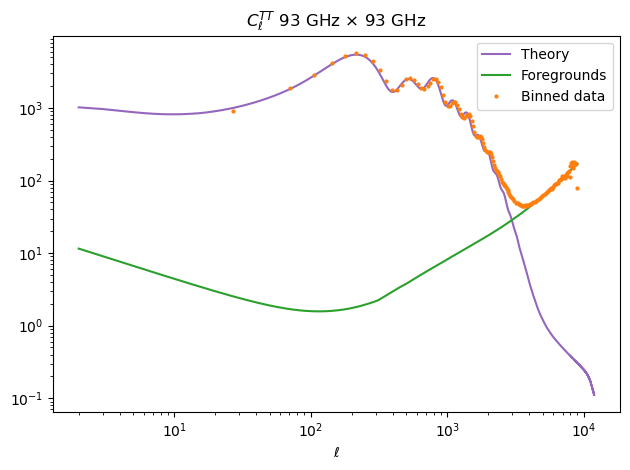

In [24]:
from matplotlib import pyplot as plt

plt.title(r"$C_\ell^{TT}$ 93 GHz $\times$ 93 GHz")
plt.loglog(Dl["ell"][2:], Dl["tt"][2:], label="Theory", color="tab:purple")
plt.loglog(Dl["ell"][2:9003], fg_totals[0][0, 0], label="Foregrounds", color="tab:green")
plt.loglog(ell_cl, Dl_data, "o", markersize=2, label="Binned data", color="tab:orange")

plt.xlabel(r"$\ell$")
plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.tight_layout()
plt.show()

### Adding More Data: Lensing Likelihood

It is also possible to include additional data to constrain the cosmological parameters further.

For example, to include **CMB lensing** reconstruction data, simply add the lensing likelihood to the `likelihood` block of the `info` dictionary: Define the lensing likelihood settings (data folder, filename, multipole ranges) and add it to `info["likelihood"]` alongside the existing MFLike likelihood. This approach works for any SOLiket likelihood—just configure and add it to the likelihood block.

In [25]:
install(
    {"likelihood": {"soliket.lensing.LensingLikelihood": None}},
    path=packages_path,
    skip_global=False,
    force=False,
    debug=True,
    no_set_global=True,
)

 2026-02-02 16:39:20,488 [install] Installing external packages at '/Users/matteoforconi/Documents/GitHub/LAT_MFLike'

likelihood:soliket.lensing.LensingLikelihood

 2026-02-02 16:39:20,495 [install] 'soliket.lensing.LensingLikelihood' could not be found as internal, trying external.
 2026-02-02 16:39:20,796 [install] Checking if dependencies have already been installed...
 2026-02-02 16:39:20,797 [install] External dependencies for this component already installed.
 2026-02-02 16:39:20,797 [install] Doing nothing.

* Summary * 

 2026-02-02 16:39:20,798 [install] All requested components' dependencies correctly installed at /Users/matteoforconi/Documents/GitHub/LAT_MFLike


True

In [26]:
lensing_config = {
    "data_folder": "LensingLikelihood/",
    "data_filename": "clkk_reconstruction_sim.fits",
    "lmax": 3000,
    "theory_lmax": 5000,
    "stop_at_error": False,
}

info["likelihood"]["soliket.LensingLikelihood"] = lensing_config

model = get_model(info)

 2026-02-02 16:39:23,626 [model] *WARNING* Ignored blocks/options: ['sampler', 'output']
 2026-02-02 16:39:23,644 [camb] `camb` module loaded successfully from /Users/matteoforconi/Documents/GitHub/CAMB-1.6.0/camb
 2026-02-02 16:39:27,355 [mflike.ttteee] Number of bins used: 3087
 2026-02-02 16:39:27,376 [mflike.ttteee] Initialized!
 2026-02-02 16:39:27,382 [soliket.lensinglikelihood] Initialising CMB Lensing...
 2026-02-02 16:39:27,382 [soliket.lensinglikelihood] Loading data from /Users/matteoforconi/Documents/GitHub/LAT_MFLike/data/LensingLikelihood/clkk_reconstruction_sim.fits...
 2026-02-02 16:39:27,416 [soliket.lensinglikelihood] Loading fiducial Cls from file: fiducial_lensing.sacc.fits


/Users/matteoforconi/.local/lib/python3.11/site-packages/sacc/tracers.py:44: UserWarning: Unknown quantity cmb_lens_potential. If possible use a pre-defined quantity, or add to the list.
  warnings.warn(f"Unknown quantity {quantity}. "


 2026-02-02 16:39:27,995 [soliket.lensinglikelihood] Loading correction factors from file: corrections_lensing.sacc.fits


/Users/matteoforconi/.local/lib/python3.11/site-packages/sacc/data_types.py:304: UserWarning: Unknown data_type value N0_00. If possible use a pre-defined type, or add to the list.
  warnings.warn(f"Unknown data_type value {data_type}. "
/Users/matteoforconi/.local/lib/python3.11/site-packages/sacc/data_types.py:304: UserWarning: Unknown data_type value N0_ee. If possible use a pre-defined type, or add to the list.
  warnings.warn(f"Unknown data_type value {data_type}. "
/Users/matteoforconi/.local/lib/python3.11/site-packages/sacc/data_types.py:304: UserWarning: Unknown data_type value N0_bb. If possible use a pre-defined type, or add to the list.
  warnings.warn(f"Unknown data_type value {data_type}. "
/Users/matteoforconi/.local/lib/python3.11/site-packages/sacc/data_types.py:304: UserWarning: Unknown data_type value N0_0e. If possible use a pre-defined type, or add to the list.
  warnings.warn(f"Unknown data_type value {data_type}. "
/Users/matteoforconi/.local/lib/python3.11/site-

In [27]:
print("loglike:")
print(
    "\tTTTEEE->",
    f"{model.loglikes(cosmo_params_camb | fg_params)[0][0]:.6g}\n",
    "\tLensing->",
    f"{model.loglikes(cosmo_params_camb | fg_params)[0][1]:.6g}",
)
print("\nlogpost ->", f"{model.logpost(cosmo_params_camb | fg_params):.6g}")

loglike:
	TTTEEE-> -48267.5
 	Lensing-> 264.417

logpost -> -48005.6


### Inspecting the Lensing data 

Lensing data is stored in a `.fits` file that can be read using `astropy`. By printing the info, it is possible to examine the extension and locate the data (in this case 8th position). Then we can collect the multipoles and the data by reading the corresponding columns. Similar to what has been done before, we access the Lensing likelihood object to obtain the theory predictions. 

In [28]:
from astropy.io import fits

fname = packages_path + "/data/LensingLikelihood/clkk_reconstruction_sim.fits"
hdul = fits.open(fname)

hdul.info()

Filename: /Users/matteoforconi/Documents/GitHub/LAT_MFLike/data/LensingLikelihood/clkk_reconstruction_sim.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  window:TopHat    1 BinTableHDU     17   0R x 3C   [D, D, D]   
  2  window:LogTopHat    1 BinTableHDU     17   0R x 3C   [D, D, D]   
  3  window:Bandpower    1 BinTableHDU     17   3000R x 2C   [K, 19D]   
  4  tracer:Misc    1 BinTableHDU     15   0R x 2C   [D, D]   
  5  tracer:Misc    1 BinTableHDU     15   0R x 2C   [D, D]   
  6  tracer:Map:ck:beam    1 BinTableHDU     19   3000R x 2C   [K, D]   
  7  tracer:Map:ck:beam    1 BinTableHDU     19   3000R x 2C   [K, D]   
  8  data:cl_00    1 BinTableHDU     24   19R x 6C   [2A, 2A, D, K, D, K]   
  9  covariance    1 ImageHDU        11   (19, 19)   float64   


In [29]:
hdul[8].columns

ColDefs(
    name = 'tracer_0'; format = '2A'
    name = 'tracer_1'; format = '2A'
    name = 'value'; format = 'D'
    name = 'window'; format = 'K'
    name = 'ell'; format = 'D'
    name = 'window_ind'; format = 'K'
)

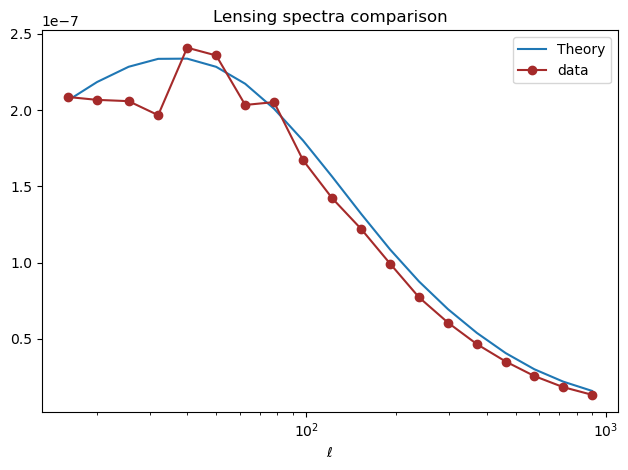

In [31]:
my_lensing = model.likelihood["soliket.LensingLikelihood"]

# Plotting data against smooth theory
plt.title("Lensing spectra comparison")
plt.plot(
    my_lensing.x,
    my_lensing._get_theory(**fiducial_cosmo_param | fiducial_foreground_param),
    # marker="o",
    label="Theory",
    color="tab:blue",
)
plt.plot(
    hdul[8].data["ell"], hdul[8].data["value"], marker="o", label="data", color="brown"
)

plt.xscale("log")
plt.xlabel(r"$\ell$")

plt.legend()
plt.tight_layout()
plt.show()